In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import RegularGridInterpolator

In [3]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [2]:
%cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
!ls

CombineControlEnvironment.ipynb  GrainEfficiency.csv		Optimization.ipynb
CombineSettingNorm.csv		 HW1a.ipynb			PowerGrainProcessNorm.csv
Field1Path.csv			 HW1.ipynb			Untitled
FlowCropNorm.csv		 NormFuelEfficiencyVsPower.csv	Untitled0.ipynb


In [10]:
# Environment definition

# Read csv's
FieldPathRaw = pd.read_csv('Field1Path.csv')
FieldPath = FieldPathRaw.to_numpy()
CombineSettingNormRaw = pd.read_csv('CombineSettingNorm.csv')
CombineSettingNorm = CombineSettingNormRaw.to_numpy()
FlowCropNormRaw = pd.read_csv('FlowCropNorm.csv')
FlowCropNorm = FlowCropNormRaw.to_numpy()
PowerGrainProcessNormRaw = pd.read_csv('PowerGrainProcessNorm.csv')
PowerGrainProcessNorm = PowerGrainProcessNormRaw.to_numpy()
GrainEfficiencyRaw = pd.read_csv('GrainEfficiency.csv')
GrainEfficiency = GrainEfficiencyRaw.to_numpy()
NormFuelEfficiencyVsPowerRaw = pd.read_csv('NormFuelEfficiencyVsPower.csv')
NormFuelEfficiencyVsPower = NormFuelEfficiencyVsPowerRaw.to_numpy()

# Constants
DurationTimeStep = 20  #sec
SpeedCombineRef = 12  #km/hr
TotalPowerRef = 399.4 #kW
EnginePowerRef = 300 #kW
FuelEfficiencyRef = 200 #g/hr/kW
BatteryCapacity = 30 #kW-hr
BatteryMaxChargeRate = 21 #kW
BatteryMaxDischargeRate = 60 #kW
MotorEfficiency = 1.0
GrainPrice = 0.04
FuelPrice = 1.0
FlowCropRef = 16569.0 #### check this
MaxPowerNormForPropulsion = 0.25
MaxHarvestDuration = FieldPath[-1,0]/(10*1000/3600) #sec, field harvest time before discounting reward


In [8]:
# Invariants from constants

# Calculate field geometry invariants
FieldMapGridDistance = FieldPath[1, 0] - FieldPath[0, 0]
GridsPerTimeStepMax = (SpeedCombineRef / FieldMapGridDistance) * DurationTimeStep
SpeedCombineGuess = np.linspace(0.02,1,49)*SpeedCombineRef*1000/3600
TimePerGrid = FieldMapGridDistance / SpeedCombineGuess
GridsPerTimeStepMax = np.round(DurationTimeStep/TimePerGrid[-1])

#build interpolation objects
PowerNormGrainHarvestInterp = RegularGridInterpolator((FlowCropNorm[:,0],CombineSettingNorm[0,:]),PowerGrainProcessNorm)
EfficiencyGrainHarvestInterp = RegularGridInterpolator((FlowCropNorm[:,0],CombineSettingNorm[0,:]),GrainEfficiency)


In [15]:
# State update function for combine environment

def UpdateCombineEnvironment(actions,logged_signals):

  # Extract actions and logged signals
  PowerEngineRequest, PowerMotorRequest, CombineSettingSetpoint = actions
  BatterySOCStartTimeStep, FieldIndexStartTimeStep, TimeHarvest = logged_signals

  # Limit inputs
  PowerEngine = max(0, min(PowerEngineRequest, EnginePowerRef))
  CombineSettingSetpoint = max(0.1, min(CombineSettingSetpoint, 1.7))

  # Adjust power inputs based on system state
  BatteryEnergy = BatterySOCStartTimeStep * BatteryCapacity
  PowerMotor = PowerMotorRequest

  # Physical limits for power requests
  if PowerMotor > BatteryMaxDischargeRate * MotorEfficiency:
    PowerMotor = BatteryMaxDischargeRate * MotorEfficiency
  elif PowerMotor < -BatteryMaxChargeRate:
    PowerMotor = -BatteryMaxChargeRate

  # Normalized power
  PowerNorm = (PowerEngine + PowerMotor) / TotalPowerRef

  # Overspecified power: meet requested engine power, reduce motor power to get total = max
  if PowerNorm > 1:
      PowerNorm = 1
      PowerMotor = PowerNorm * TotalPowerRef - PowerEngine

  # Iterate combine speed for each grid - exhaustive search
  MaxFieldIndex = FieldIndexStartTimeStep + GridsPerTimeStepMax
  FieldIndex = FieldIndexStartTimeStep
  TimeCumulative = 0.0
  SpeedCombineGrid = []
  CropRateNormGrid = []
  TimeGrid = []
  PowerEngineGrid = []
  PowerMotorGrid = []
  BatteryEnergyGrid = []

  while TimeCumulative < DurationTimeStep and FieldIndex <= (MaxFieldIndex):
    CropRateNorm = FieldPath[FieldIndex, 1] * (1. / TimePerGrid) * (3600. / FlowCropRef)
    PowerNormGrainHarvestGuess = []
    for k in range(len(CropRateNorm)):
      if CropRateNorm[k] > FlowCropNorm[-1,0]:
        CropRateNorm[k] = FlowCropNorm[-1,0]
      elif CropRateNorm[k] < FlowCropNorm[0,0]:
        CropRateNorm[k] = FlowCropNorm[0,0]
      # Calculate power to process crop
      PowerNormGrainHarvestGuess = np.append(PowerNormGrainHarvestGuess,PowerNormGrainHarvestInterp([CropRateNorm[k],CombineSettingSetpoint]))

    # Calculate power available to propel combine
    PowerNormForPropulsion = PowerNorm - PowerNormGrainHarvestGuess

    # Check battery SOC at end of grid
    BatteryEnergy = BatteryEnergy - PowerMotor * (TimePerGrid / 3600)  # kWh
    BatterySOCInterp = BatteryEnergy / BatteryCapacity
    #limit motor power based on SOC limits
    PowerEngineInterp = np.ones(np.shape(PowerNormForPropulsion))*PowerEngine
    PowerMotorInterp = np.ones(np.shape(PowerNormForPropulsion))*PowerMotor

    for k2 in range(len(BatterySOCInterp)):
      if BatterySOCInterp[k2] < 0.1 and PowerMotor >= 0:  # Stop discharging
          PowerMotorInterp[k2] = 0
          PowerNormForPropulsion[k2] = PowerEngineInterp[k2] / TotalPowerRef - PowerNormGrainHarvestGuess[k2]
      elif BatterySOCInterp[k2] > 0.9 and PowerMotor <= 0:  # Stop charging
          PowerMotorInterp[k2] = 0
          PowerNormForPropulsion[k2] = PowerEngineInterp[k2] / TotalPowerRef - PowerNormGrainHarvestGuess[k2]

      if PowerNormForPropulsion[k2] < 0:
          PowerNormForPropulsion[k2] = 0  # 0 power for propulsion is the minimum possible

    # Calculate combine speed from power
    SpeedFromPower = (PowerNormForPropulsion / MaxPowerNormForPropulsion)**0.5 * (SpeedCombineRef * 1000 / 3600)

    # Calculate combine speed error
    Error2SpeedCombine = (SpeedCombineGuess - SpeedFromPower) ** 2
    MinError2SpeedCombine = np.min(Error2SpeedCombine)
    for k in range(len(Error2SpeedCombine)):
      if Error2SpeedCombine[k] == MinError2SpeedCombine:
        if SpeedCombineGuess[k] == SpeedCombineRef:
          PowerNormGrid = MaxPowerNormForPropulsion+PowerNormGrainHarvestGuess[k]
          PowerEngineGrid = np.append(PowerEngineGrid,PowerNormGrid*TotalPowerRef-PowerMotorInterp[k]) #kW, combine speed is governed
        else:
          PowerEngineGrid = np.append(PowerEngineGrid,PowerEngineInterp[k]) #kW
        SpeedCombineGrid = np.append(SpeedCombineGrid,SpeedCombineGuess[k] / 1000 * 3600)  # km/hr
        CropRateNormGrid = np.append(CropRateNormGrid,CropRateNorm[k])
        TimeGrid = np.append(TimeGrid,TimePerGrid[k]) #sec

        PowerMotorGrid = np.append(PowerMotorGrid,PowerMotorInterp[k]) #kW
        BatteryEnergy = BatteryEnergy[k]
        BatteryEnergyGrid = np.append(BatteryEnergyGrid,BatteryEnergy) #kW-hr

    TimeCumulative = TimeCumulative + TimeGrid[-1] #sec
    FieldIndex = FieldIndex+1

  BatterySOCGrid = BatteryEnergyGrid / BatteryCapacity
  FieldIndexEndTimeStep = FieldIndex
  TimeHarvest = TimeHarvest+TimeCumulative #sec

  # Calculate grain harvested and fuel consumed in time step
  # Interpolate Grain Efficiency per Grid
  EfficiencyGrainHarvestGrid = []
  for k in range(len(CropRateNormGrid)):
    EfficiencyGrainHarvestGrid = np.append(EfficiencyGrainHarvestGrid,EfficiencyGrainHarvestInterp([CropRateNormGrid[k],CombineSettingSetpoint]))
  # Calculate Grain Harvest per Grid
  GrainPerGrid = FieldPath[FieldIndexStartTimeStep:FieldIndexEndTimeStep, 2] * EfficiencyGrainHarvestGrid

  # Calculate Fuel Consumption Grid
  SpecificFuelConsumptionGrid = np.interp(PowerEngineGrid / EnginePowerRef, NormFuelEfficiencyVsPower[:, 0], NormFuelEfficiencyVsPower[:, 1], left=np.nan, right=np.nan) * FuelEfficiencyRef  # g/kW/hr
  FuelRateGrid = SpecificFuelConsumptionGrid * PowerEngineGrid / (0.82 * 3.785 * 1000)  # gal/hr
  FuelConsumptionGrid = FuelRateGrid * (TimeGrid / 3600)  # gal

  # Calculate Grain Harvested, Fuel Consumed, Grain Harvest Value, and Fuel Cost for time step
  GrainHarvested = np.sum(GrainPerGrid)  # bu in time step
  FuelConsumed = np.sum(FuelConsumptionGrid)  # gal in time step
  GrainHarvestValue = GrainHarvested * GrainPrice  # $
  if TimeHarvest > MaxHarvestDuration:
    GrainHarvestValue = GrainHarvested * GrainPrice * 0.75  # $, discount for taking too long to harvest
  FuelCost = FuelConsumed * FuelPrice  # $

  # Calculate SpeedCombine and EfficiencyGrainHarvest
  SpeedCombine = np.sum(SpeedCombineGrid * (TimeGrid / TimeCumulative)) #km/hr, weighted average speed for time step
  EfficiencyGrainHarvest = np.sum(EfficiencyGrainHarvestGrid * (TimeGrid / TimeCumulative)) #weighted average efficiency for time step

  # Calculate BatterySOC
  BatterySOC = BatterySOCGrid[-1]

  # Calculate StateVector
  state_vector = [SpeedCombine, EfficiencyGrainHarvest, BatterySOC]

  # Calculate Reward
  reward = GrainHarvestValue - FuelCost

  # Diagnostics
  #PowerEngineMean = np.sum(PowerEngineGrid * (TimeGrid / TimeCumulative))
  #PowerMotorMean = np.sum(PowerMotorGrid * (TimeGrid / TimeCumulative))
  #diagnostics = [PowerEngineMean, PowerMotorMean]

  # Calculate FieldIndexStartNextTimeStep
  FieldIndexStartNextTimeStep = FieldIndexEndTimeStep + 1

  # Update LoggedSignals.StartTimeStep
  logged_signals = [BatterySOC, FieldIndexStartNextTimeStep, TimeHarvest]

  if (len(FieldPath[:, 0]) - GridsPerTimeStepMax) < FieldIndexStartNextTimeStep:
      is_done = 1
  else:
      is_done = 0

  return state_vector, reward, is_done, logged_signals


In [22]:
def ResetCombineEnvironment():
  state_vector = [10,0.95,0.5]
  logged_signals = [0.5,0,0] # battery soc, starting field index, cumulative time to harvest field
  #make starting field index random?
  return state_vector, logged_signals

In [20]:
# Manual settings

# Actions - initial setting
actions_from_agent = [300.0,50.0,1.03]
logged_signals = [0.5,0,0]
is_done = 0
BatteryState = 1 #discharging

# State, reward update from environment
combine_speed_all = []
grain_efficiency_all = []
battery_soc_all = []
reward_all = []
combine_control_setting_all = []

while is_done == 0:
  #update state
  state_vector, reward, is_done, logged_signals = UpdateCombineEnvironment(actions_from_agent,logged_signals)
  combine_speed_all = np.append(combine_speed_all,state_vector[0])
  grain_efficiency_all = np.append(grain_efficiency_all,state_vector[1])
  battery_soc_all = np.append(battery_soc_all,state_vector[2])
  reward_all = np.append(reward_all,reward)
  combine_control_setting_all = np.append(combine_control_setting_all,actions_from_agent[2])

  #update actions based on state feeback
  #combine control
  CombineControlSetpointMax = 0.7*state_vector[0]/10+0.35
  Gain = 0.5
  actions_from_agent[2] = actions_from_agent[2]+Gain*(CombineControlSetpointMax-actions_from_agent[2])
  #battery SOC
  if actions_from_agent[1] >= 0: #discharging battery
    if state_vector[2] < 0.2: #battery reached min charge target
      actions_from_agent[1] = -40 #charge battery at max rate
  else:
    if state_vector[2] > 0.7: #battery reached max charge target
      actions_from_agent[1] = 50 #discharge battery



259.29929852865394


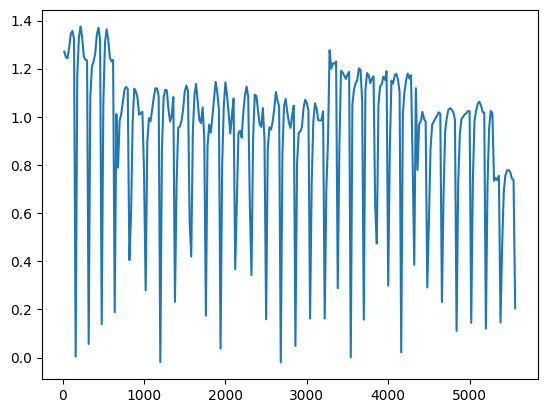

In [21]:
# Plot results
reward_sum = np.sum(reward_all)
print(reward_sum)

TimeChannel = np.linspace(1,len(reward_all),len(reward_all))*DurationTimeStep
plt.plot(TimeChannel,reward_all)
